# Cleaning

This notebook illustrates detailed download and cleaning of the Chicago Crash data. 

Our Problem focused on what factors contribute to **severe** traffic incidents at **night**. 

* **Severe** traffic incidents we defined as `FATAL` or `INCAPACITATING` from the `INJURY_TYPE` column. 

* **Night** we defined as the hours between 10pm to 5 am, or hours `22` through `5` in the `CRASH_HOUR` column. 

* Final output is `final_df` which will be used in the following notebook(s).

### Loading the Neccessary Packages and CSV Files

In [1]:
#Importing the neccessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
crash_df = pd.read_csv('data/Traffic_Crashes_-_crashes.csv')
people_df = pd.read_csv('data/Traffic_Crashes_-_people.csv', low_memory=False)
vehicle_df = pd.read_csv('data/Traffic_Crashes_-_vehicles.csv', low_memory=False)

### Dropping Unneccessary Columns

#### `crash_df` dropping Justification: 

* `RD_NO` - Police Dep. Report number, another identifying number associated with each record, we kept `CRASH_RECORD_ID` as the joining record number for each dataframe. 
* `CRASH_DATE_EST_I` - used when crash is reported to police days after the crash, this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `CRASH_DATE` - this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `REPORT_TYPE` - administrative report type, not a factor relevant to causing a crash.
* `HIT_AND_RUN_I` - not a factor relevant to causing a crash.
* `DATE_POLICE_NOTIFIED` - not a factor relevant to causing a crash.
* `STREET_NO` - of location related data we chose to keep latitude, longitude
* `BEAT_OF_OCCURENCE` - not a factor relevant to causing a crash.
* `PHOTOS_TAKEN_I` - not a factor relevant to causing a crash.
* `STATEMENTS_TAKEN` - not a factor relevant to causing a crash.
* `MOST_SEVERE_INJURY` - basing our severity of injury off of information from the `people_df` dataframe, including this and other injury related columns would cause multicolliniarity in our modeling. 
* `INJURIES_FATAL`
* `INJURIES_NON_INCAPACITATING`
* `INJURIES_REPORTED_NOT_EVIDENT`
* `INJURIES_NO_INDICATION`
* `INJURIES_UNKNOWN`
* `LONGITUDE`
* `LATITUDE`

In [3]:
crash_df_dropped = crash_df[['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 
                                          'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'LANE_CNT', 
                                          'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'NOT_RIGHT_OF_WAY_I',
                                          'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 
                                          'DOORING_I','WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 
                                          'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']]

#### `people_df` dropping Justification: 

* `PERSON_ID` - unique ID for each person record, 

... do we need to fill in reasons for all these? 

In [4]:
people_df_dropped = people_df[['CRASH_RECORD_ID', 'PERSON_TYPE', 'AGE', 'DRIVERS_LICENSE_STATE',
                                'DRIVER_ACTION', 'DRIVER_VISION', 'BAC_RESULT VALUE', 
                                'INJURY_CLASSIFICATION']]

#### `vehicle_df` dropping Justification: 

* `---`, 

... do we need to fill in reasons for all these? 

In [5]:
vehicle_df_dropped = vehicle_df[['CRASH_RECORD_ID', 'VEHICLE_YEAR', 'MANEUVER']]

## Subsetting crash records between 10 pm and 5 am

In [6]:
night_time_df = crash_df_dropped.copy()
night_time_df = night_time_df[(night_time_df['CRASH_HOUR'] >= 22) | (night_time_df['CRASH_HOUR'] <= 6)]
night_time_df.columns

Index(['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'LANE_CNT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'NOT_RIGHT_OF_WAY_I',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'DOORING_I',
       'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'],
      dtype='object')

## Joining all three data sets

In [7]:
#checking the shape
night_time_df.shape, people_df_dropped.shape

((93448, 18), (1226112, 8))

In [8]:
merge1 = pd.merge(night_time_df, people_df_dropped, how='left', on='CRASH_RECORD_ID')
merge1.shape

(188737, 25)

## Further Exploring Columns

#### `INJURY_CLASSIFICATION` target Variable - this includes all people involved in incident, cyclists, passengers, drivers, etc. 

In [9]:
merge1['INJURY_CLASSIFICATION'].value_counts()

NO INDICATION OF INJURY     166740
NONINCAPACITATING INJURY     12731
REPORTED, NOT EVIDENT         5501
INCAPACITATING INJURY         2834
FATAL                          310
Name: INJURY_CLASSIFICATION, dtype: int64

In [10]:
# fatal / incapacitate = 1
merge1.loc[(merge1['INJURY_CLASSIFICATION'] == 'FATAL') | 
           (merge1['INJURY_CLASSIFICATION'] == 'INCAPACITATING INJURY'), 'INJURY_CLASSIFICATION'] = '1'

# else = 0
merge1.loc[(merge1['INJURY_CLASSIFICATION'] == 'NO INDICATION OF INJURY') | 
           (merge1['INJURY_CLASSIFICATION'] == 'NONINCAPACITATING INJURY') |
           (merge1['INJURY_CLASSIFICATION'] == 'REPORTED, NOT EVIDENT'), 'INJURY_CLASSIFICATION'] = '0'

merge1['INJURY_CLASSIFICATION'].fillna('0', inplace=True)

In [11]:
merge1["INJURY_CLASSIFICATION"].value_counts(normalize=True)

0    0.983342
1    0.016658
Name: INJURY_CLASSIFICATION, dtype: float64

In [12]:
final_df = merge1.copy()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188737 entries, 0 to 188736
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          188737 non-null  object 
 1   TRAFFIC_CONTROL_DEVICE   188737 non-null  object 
 2   DEVICE_CONDITION         188737 non-null  object 
 3   WEATHER_CONDITION        188737 non-null  object 
 4   LIGHTING_CONDITION       188737 non-null  object 
 5   LANE_CNT                 68969 non-null   float64
 6   ROADWAY_SURFACE_COND     188737 non-null  object 
 7   ROAD_DEFECT              188737 non-null  object 
 8   NOT_RIGHT_OF_WAY_I       6792 non-null    object 
 9   PRIM_CONTRIBUTORY_CAUSE  188737 non-null  object 
 10  SEC_CONTRIBUTORY_CAUSE   188737 non-null  object 
 11  DOORING_I                388 non-null     object 
 12  WORK_ZONE_I              1105 non-null    object 
 13  WORK_ZONE_TYPE           822 non-null     object 
 14  WORK

In [25]:
final_df['DRIVER_ACTION'].value_counts()

UNKNOWN                              47136
NONE                                 44126
OTHER                                14086
FAILED TO YIELD                      10052
FOLLOWED TOO CLOSELY                  7284
DISREGARDED CONTROL DEVICES           4597
TOO FAST FOR CONDITIONS               4233
IMPROPER TURN                         3797
IMPROPER BACKING                      3733
IMPROPER LANE CHANGE                  3583
IMPROPER PASSING                      2515
WRONG WAY/SIDE                        1225
EVADING POLICE VEHICLE                 469
IMPROPER PARKING                       436
CELL PHONE USE OTHER THAN TEXTING      350
OVERCORRECTED                          302
EMERGENCY VEHICLE ON CALL              247
TEXTING                                104
STOPPED SCHOOL BUS                      13
LICENSE RESTRICTIONS                    10
Name: DRIVER_ACTION, dtype: int64

In [21]:
final_df['ROAD_DEFECT'].value_counts()

NO DEFECTS           155321
UNKNOWN               29187
RUT, HOLES             1397
WORN SURFACE           1181
OTHER                  1052
SHOULDER DEFECT         374
DEBRIS ON ROADWAY       225
Name: ROAD_DEFECT, dtype: int64

#### Exporting the `final_df` into csv file

In [13]:
clean_data = final_df.to_csv('clean_data.csv', index = False)

# Binning Categoricals

In [14]:
final_df['TRAFFIC_CONTROL_DEVICE'].value_counts()

NO CONTROLS                 92853
TRAFFIC SIGNAL              67508
STOP SIGN/FLASHER           19102
UNKNOWN                      6326
OTHER                        1036
LANE USE MARKING              632
YIELD                         320
OTHER WARNING SIGN            218
OTHER REG. SIGN               171
RAILROAD CROSSING GATE        167
FLASHING CONTROL SIGNAL       118
POLICE/FLAGMAN                 94
OTHER RAILROAD CROSSING        45
PEDESTRIAN CROSSING SIGN       43
SCHOOL ZONE                    30
RR CROSSING SIGN               27
DELINEATORS                    27
NO PASSING                     12
BICYCLE CROSSING SIGN           8
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64

In [15]:
final_df.loc[final_df.TRAFFIC_CONTROL_DEVICE == 'NO CONTROLS', 'TRAFFIC_CONTROL_DEVICE'] = 0
final_df.loc[final_df.TRAFFIC_CONTROL_DEVICE != 0, 'TRAFFIC_CONTROL_DEVICE'] = 1

In [16]:
final_df['TRAFFIC_CONTROL_DEVICE'].value_counts()

1    95884
0    92853
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64

In [18]:
final_df['DEVICE_CONDITION'].value_counts()

NO CONTROLS                 93293
FUNCTIONING PROPERLY        79342
UNKNOWN                     12787
OTHER                        1370
FUNCTIONING IMPROPERLY       1268
NOT FUNCTIONING               593
WORN REFLECTIVE MATERIAL       59
MISSING                        25
Name: DEVICE_CONDITION, dtype: int64

In [19]:
final_df.loc[final_df.DEVICE_CONDITION == 'FUNCTIONING PROPERLY', 'DEVICE_CONDITION'] = 1
final_df.loc[final_df.DEVICE_CONDITION != 1, 'DEVICE_CONDITION'] = 0

In [20]:
final_df['DEVICE_CONDITION'].value_counts()

0    109395
1     79342
Name: DEVICE_CONDITION, dtype: int64

In [23]:
final_df['DRIVERS_LICENSE_STATE'].value_counts()

0     92853
IL    49837
XX     1355
IN     1004
WI      288
      ...  
PQ        1
PT        1
CD        1
KZ        1
IT        1
Name: DRIVERS_LICENSE_STATE, Length: 90, dtype: int64

In [22]:
final_df.loc[final_df.TRAFFIC_CONTROL_DEVICE == 'IL', 'DRIVERS_LICENSE_STATE'] = 1
final_df.loc[final_df.TRAFFIC_CONTROL_DEVICE != 1, 'DRIVERS_LICENSE_STATE'] = 0

In [ ]:
final_df['DRIVERS_LICENSE_STATE'].value_counts()

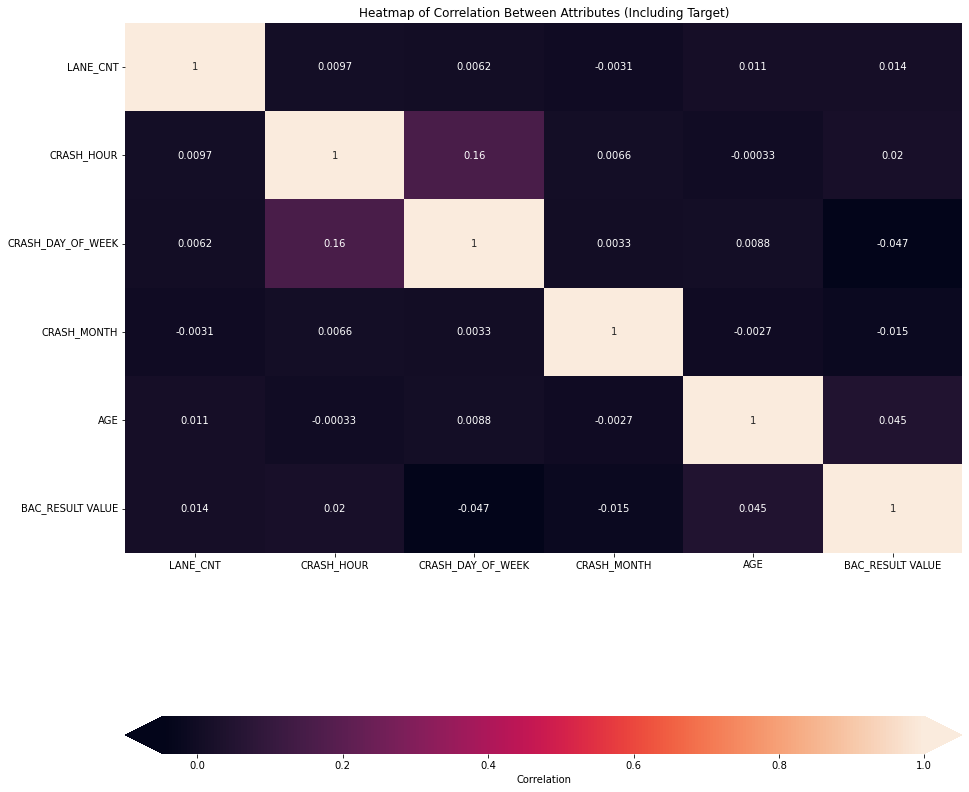

In [17]:
# Create a df with the target as the first column,
# then compute the correlation matrix
corr = final_df.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    # mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");